In [1]:
from IPython.display import Image


## Purpose :
#### Predict NYC Taxi trip duration in `RMSLE` metric ( Root Mean Squared Logarithmic Error) 

- https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation



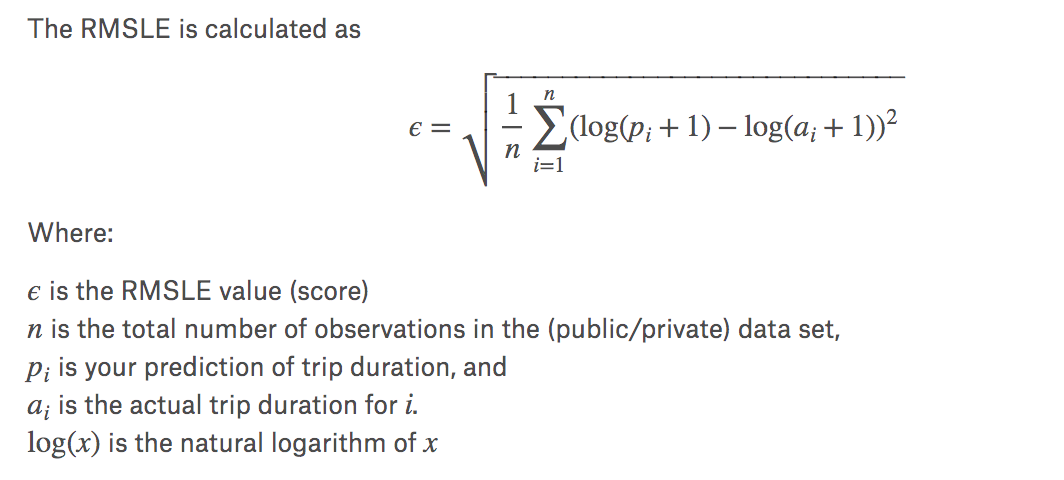

In [2]:
Image(filename='../NYC_Taxi_Trip_Duration/documents/RMSLE.png') 


## Process : 
    - 0 Feature engineering 
    - 0'Data cleaning 
    - 1 Simple modeling 
        -1.1 linear regression
        -1.2 lasso regression
        -1.3 decision tree regression
        -1.4 logistic regression ***
    - 2 SELECT MODELS 
        -2.1 parameter select 
        -2.2 model tuning
    - 3 PREDICTION ENSEMBLE 

In [3]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
from IPython.display import Image 

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

In [5]:
# basic feature extract 

def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff 
    df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
    df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    return df_


# get weekday
import calendar
def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_train.pickup_datetime,coerce=True).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_
    



In [6]:
df_train_ = basic_feature_extract(df_train)

In [7]:
df_train_ = get_duration(df_train_)

In [8]:
df_train_ = get_weekday(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:25: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [9]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


## 0) Feature engineering 

In [10]:
# feature extract


###  distance 
# https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-377?scriptVersionId=1369021


# Haversine distance
# common distance method in geopy

def get_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads

def get_manhattan_distance(lat1, lng1, lat2, lng2):
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


In [11]:
###  USING .loc making return array ordering 

# get haversine distance 
df_train_.loc[:, 'distance_haversine'] = get_haversine_distance(
                      df_train_['pickup_latitude'].values,
                      df_train_['pickup_longitude'].values,
                      df_train_['dropoff_latitude'].values,
                      df_train_['dropoff_longitude'].values)

# get manhattan distance 

df_train_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                      df_train_['pickup_latitude'].values,
                      df_train_['pickup_longitude'].values,
                      df_train_['dropoff_latitude'].values,
                      df_train_['dropoff_longitude'].values)


In [12]:
#df_train_[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','distance_manhattan']]

df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_,distance_haversine,distance_manhattan
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,2016-03-14,17,2016,03,0,00:07:35,0,Monday,1.498521,1.735433


### 0-1) Duration VS. Distance 

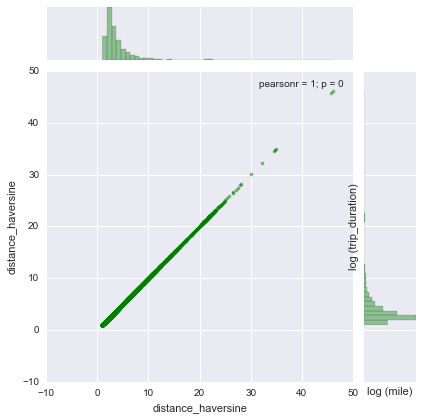

In [13]:
# ref 
# https://www.kaggle.com/hanriver0618/nyc-taxi-data-exploration-visualization

# haversine distance VS duration 
# or u can plot all data points, still a linear relation 
#sns.jointplot(np.log10(df_train_["distance_haversine"][:10000]+1),np.log10(df_train_["distance_haversine"][:10000]+1),s=10,alpha=0.5,color='green')
sns.jointplot((df_train_["distance_haversine"][:10000]+1),(df_train_["distance_haversine"][:10000]+1),s=10,alpha=0.5,color='green')
plt.xlabel('log (mile)')
plt.ylabel('log (trip_duration)')

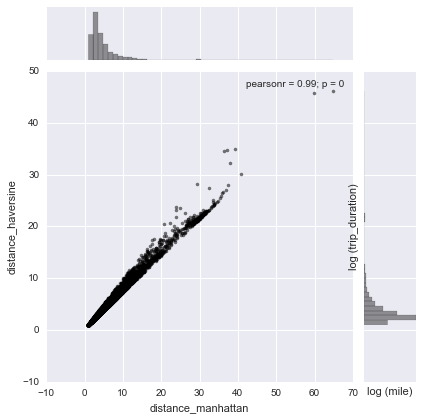

In [14]:
# manhattan distance VS duration 
# or u can plot all data points, still a linear relation
sns.jointplot((df_train_["distance_manhattan"][:10000]+1),(df_train_["distance_haversine"][:10000]+1),s=10,alpha=0.5,color='black')
plt.xlabel('log (mile)')
plt.ylabel('log (trip_duration)')

#### There are linear relations within `distance and duration`  in the cases : 
    - (logarithm) haversine distance VS. duration 
    - (logarithm) manhattan distance VS. duration 
   which fit common sense: trip takes longer when distance longer 
 

### 0-2) velocity (driving speed)

## 0') Data cleaning 

In [15]:
# data cleaning help function


# just simple remove too big /small data points in features, will do further after
# data cleaning analysis

def clean_data(df):
    df_ = df.copy()
    # remove possible outlier in haversine distance 
    df_ = df_[(df_['distance_haversine'] < df_['distance_haversine'].quantile(0.95))&
         (df_['distance_haversine'] > df_['distance_haversine'].quantile(0.05))]
    # remove possible outlier in trip duration 
    df_ = df_[(df_['trip_duration'] < df_['trip_duration'].quantile(0.95))&
         (df_['trip_duration'] > df_['trip_duration'].quantile(0.05))]

    return df_
       
   

## 1) Simple modeling 

In [171]:
#  modeling help function 

from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def sample_split(df):
    #data =  data[selected_feature]
    relevent_cols = list(df)
    data=df.values.astype(float)             
    Y = data[:,0]
    X = data[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test,X,Y

def reg_analysis(model, df):
    # get train, test set amd X,y here (for cross-validation) 
    X_train, X_test, y_train, y_test,X,Y = sample_split(df)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # Cross-validation score
    cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
    print ('cv model score = ',cross_val_score(model, X, Y, cv=cv))
    # Model score
    print ('Model score = ',model.score(X_test,y_test))
    # RMSLE score
    sum=0.0
    for x in range(len(prediction)):
        p = np.log(prediction[x]+1)
        r = np.log(y_test[x]+1)
        sum = sum + (p - r)**2
    print ('RMSLE score =  ',(sum/len(prediction))**0.5)
    #return model
    

def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5


In [17]:
#df_train_.columns

### 1-1) linear regression

In [144]:
df_train_linear_ = clean_data(df_train_)

In [153]:
linear_feature = ['trip_duration', #'distance_haversine',
                  'distance_manhattan']

In [156]:
# train, test seperate 
# 70% train, 30% test 
#X_train, X_test, y_train, y_test = sample_split(df_train_linear_[linear_feature])

In [167]:
from sklearn import linear_model
linear_model = linear_model.LinearRegression()
#reg_analysis(linear_model,X_train, X_test, y_train, y_test)
reg_analysis(linear_model,df_train_linear_[linear_feature])

cv model score =  [ 0.41912792  0.41694982  0.41525451  0.41900032]
Model score =  0.418188235892
RMSLE score =   0.402145812089


Linear model score : 0.418188235892


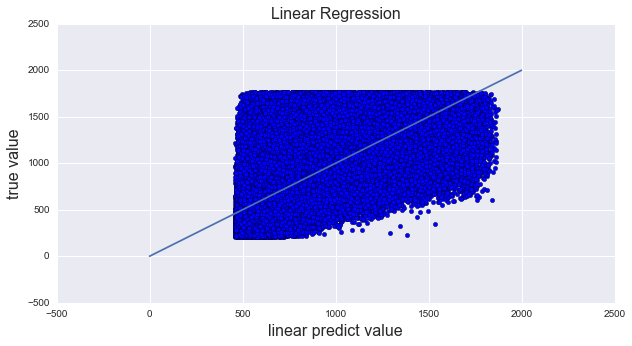

In [23]:
# Linear model 

from sklearn import linear_model

#fitting
linear_model = linear_model.LinearRegression()
linear_model.fit(X_train,y_train)
y_linear_fit = linear_model.predict(X_test)
print ('Linear model score :', linear_model.score(X_test,y_test))

# visualize 
plt.figure(figsize=(10,5))
plt.scatter(y_linear_fit,y_test, label = 'training points')
# hardcode here, just want a y=x line 
x = range(0,2000)
y = range(0,2000)
plt.plot(x, y)

# plot labels
plt.xlabel('linear predict value',fontsize=16);
plt.ylabel('true value',fontsize=16);
plt.title('Linear Regression',fontsize=16)
plt.show()


## 1-2) lasso regression

In [69]:
df_train_lasso_ = clean_data(df_train_)

In [148]:
#lasso_feature = ['trip_duration', #'distance_haversine',
#       'distance_manhattan']

lasso_feature = ['trip_duration', 'vendor_id', 
                 'passenger_count', #'store_and_fwd_flag',
                 'pickup_hour','pickup_month', 
                 'pickup_weekday','dropoff_hour',
                 'dropoff_month','distance_haversine',
                 'distance_manhattan']

In [169]:
from sklearn import linear_model
lasso_model = linear_model.Lasso(alpha=0.5)
reg_analysis(lasso_model,df_train_lasso_[lasso_feature])

cv model score =  [ 0.44531214  0.44337475  0.44111828  0.44480347]
Model score =  0.444347415588
RMSLE score =   0.39273774064


### 1-3) decision tree regression

In [98]:
df_train_tree_ = clean_data(df_train_)

In [149]:
#df_train_[tree_feature].head(1)

In [138]:
tree_feature = ['trip_duration', 'vendor_id', 
                'passenger_count', 'pickup_longitude', 
                'pickup_latitude','dropoff_longitude',
                'dropoff_latitude','pickup_hour','pickup_month',
                'dropoff_hour','dropoff_month',  
                'distance_haversine','pickup_weekday',
                'distance_manhattan']

In [170]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
reg_analysis(tree_model,df_train_tree_[tree_feature])

cv model score =  [ 0.42197232  0.41638607  0.41977673  0.41896844]
Model score =  0.421716183582
RMSLE score =   0.389109203525


### 1-4) logistic regression *** (need to fix )

In [96]:
#logistic_feature = ['trip_duration', #'distance_haversine',
#       'distance_manhattan']
#df_train_logistic_ = clean_data(df_train_)
# only run 5000 data points here, since logistics start running slow when data >10k
#X_train, X_test, y_train, y_test = sample_split(df_train_logistic_[logistic_feature].head(5000))
#X_train, X_test, y_train, y_test = sample_split(df_train_logistics_[logistics_feature])
#from sklearn.linear_model import LogisticRegression
# http://www.jianshu.com/p/bbdeb356057e
# using all CPUs with n_jobs=-1
# process will run faster with solver='sag' 
#logistic_model = LogisticRegression(n_jobs=-1,tol = 0.1,solver='sag')
#reg_analysis(logistic_model,X_train, X_test, y_train, y_test)